In [1]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities.visualization import Visualizer
import keras
from keras import Model
from keras import optimizers
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer
from utilities.data_reader import DataReader
from utilities.mapping import Mapper
from distance.EuclideanDistance import EuclideanDistance
from metrics.Product import Product
from utilities.test_products_generator import TestProductsGenerator
from metrics.Metrics import Metrics

# Hyperparameters

In [2]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 280
validation_triplets = 40
training_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training"
validation_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation"

# Creating training dataset from generator 

In [3]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                method="triplet_loss")
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


# Creating validation dataset from generator

In [4]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  max_iterations=validation_triplets,
                                                  method="triplet_loss")
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(100, 100, 3)


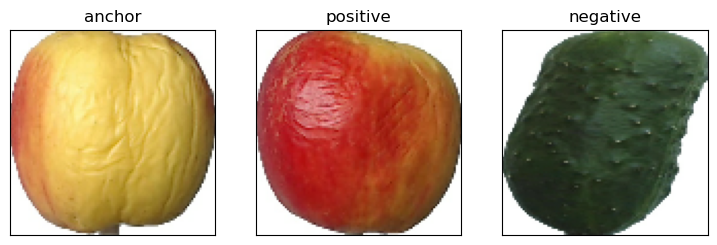

In [5]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

(100, 100, 3)


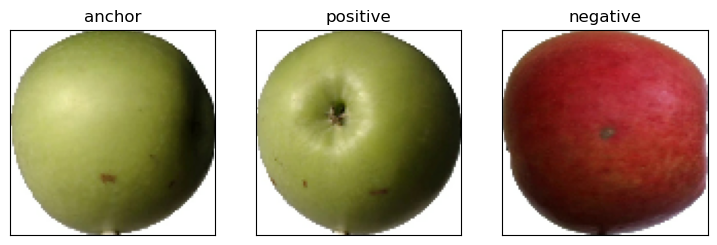

In [6]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img, "negative" : negative_img})
print(anchor_img.shape)

# Creating siamese model

In [7]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [8]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Compilation of our model and summary

In [9]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001))
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ ?                      │       230,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,902 (901.96 KB)

 Trainable params: 199,920 (780.94 KB)

 Non-trainable params: 30,982 (121.02 KB)

# Training 

In [10]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset)

Epoch 1/10
     18/Unknown 6s 197ms/step - loss: 0.2008

C:\Users\matim\Apps\Anaconda3\envs\ml\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - loss: 0.1974 - val_loss: 0.0586
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - loss: 0.0752 - val_loss: 0.0229
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - loss: 0.0290 - val_loss: 0.0750
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0253 - val_loss: 0.0641
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - loss: 0.0303 - val_loss: 0.1081
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0318 - val_loss: 0.0203
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0540 - val_loss: 0.0722
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0444 - val_loss: 0.0125
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0252 - val_loss: 0.0070
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.0400 - val_loss: 0.0127


# Loading all the representatives of product types 

In [11]:
path = r".\data\Fruits360_Products"
products_paths = DataReader.read_types_of_products(path)
products_dictionary = DataReader.generate_images_classes_dict(products_paths)
k, v = products_dictionary.items().__iter__().__next__()
print(k)
print(v)

.\data\Fruits360_Products\apple_6
['.\\data\\Fruits360_Products\\apple_6\\r0_107.jpg']


# Mapping representatives and parsing into Product objects

In [12]:
representatives = []
mapper = Mapper(image_size)
for label, product in products_dictionary.items():
    rep = Product()
    rep.label, rep.image = mapper.map_single_product(label, product[0])
    rep.label = rep.label.rsplit('\\', 1)[1]
    rep.image_path = product[0]
    representatives.append(rep)
print(representatives[0].label, representatives[0].image_path, representatives[0].image)

apple_6 .\data\Fruits360_Products\apple_6\r0_107.jpg tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(100, 100, 3), dtype=float32)


# Reshaping the images so as they would fit into out model

In [13]:
for r in representatives:
    r.image = tf.reshape(r.image, shape=(1,100,100,3))
    
print(representatives[0].image)

tf.Tensor(
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]], shape=(1, 100, 100, 3), dtype=float32)


# Evaluating embeddings for all representatives

In [14]:
for r in representatives:
    r.embedding = np.asarray(embedding_model(r.image)).astype('float32')
print(representatives[0].embedding)

[[ 0.7812175   0.8284356   0.03194198 -0.362939   -0.6778209   0.7788974
   0.87667686 -0.1115594   0.25938526 -0.86454755]]


# Creating a generator for test images

In [15]:
test_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Test"
test_generator = TestProductsGenerator(test_path)

# Calculating the overall efficiency of the model based on the testing dataset 

In [16]:
efficiency_sum = 0
test_length = 0
mapper = Mapper(image_size)

for l, p in test_generator.get_next_element():
    label, image = mapper.map_single_product(l, p)
    label = label.rsplit('\\', 1)[1]
    image_path = p
    image = tf.reshape(image, shape=(1,100,100,3))
    embedding = np.asarray(embedding_model(image)).astype('float32')
    distances = np.zeros(len(representatives))
    labels = []
    for i in range(len(representatives)):
        distances[i] = EuclideanDistance.calculate_distance((embedding, representatives[i].embedding))
        labels.append(representatives[i].label)
    top5_dist, top5_labels = Metrics.find_top_5(distances,labels)
    efficiency_sum += Metrics.calculate_efficiency(label, top5_labels) 
    test_length += 1
overall_efficiency = efficiency_sum / test_length
print(overall_efficiency)
print(test_length)

0.9690675241157616
3110
